In [1]:
# Import libs
import torch 
import numpy as np

# train on gpu
torch.cuda.empty_cache()
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CPU")
else:
    print("GPU")

GPU


In [14]:
# Libs
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms 

# Params
num_workers = 4
batch_size = 16
val_size = 0.1

# Transformations
train_transform = transforms.Compose([
    #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)), # with augmentation
    #transforms.RandomRotation(degrees=15),
    #transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Paths
train_data_path = 'data/train/'
test_data_path = 'data/test/'
valid_data_path = 'data/val/'

# Load dataset
train_dataset = torchvision.datasets.ImageFolder(root=train_data_path, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_data_path, transform=test_transform)
val_dataset = torchvision.datasets.ImageFolder(root=valid_data_path, transform=valid_transform)

# Make val size smaller
"""
num_val = len(val_dataset)
indices = list(range(num_val))
np.random.shuffle(indices)
shorten = int(np.floor(val_size, num_val))
val_idx = indices[shorten:]

val_sampler = SubsetRandomSampler(val_idx)
"""
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=num_workers, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=False, pin_memory=False)

# Output classes
classes = ['Normal', 'Pneumonia']

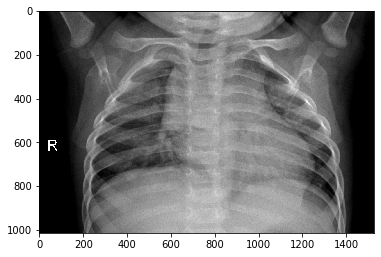

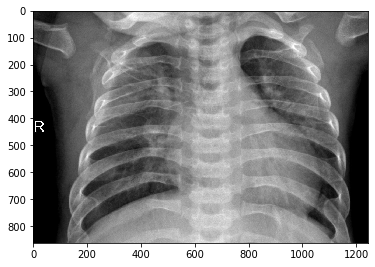

In [15]:
# Libs
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

def imgshow(img):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap="gray")
    plt.show()

x = Image.open(train_data_path + "NORMAL/IM-0128-0001.jpeg")
y = Image.open(train_data_path + "PNEUMONIA/person1001_bacteria_2932.jpeg")
np.array(x).shape
np.array(y).shape
imgshow(x)
imgshow(y)

trainiter = iter(train_loader)
features, labels = next(trainiter)
torch.cuda.empty_cache()

In [3]:
# Libs
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # CNN
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2,2)
        
        # FC
        self.fc1 = nn.Linear(128 * 28 * 28, 2048)
        self.fc2 = nn.Linear(2048, 256) 
        self.fc3 = nn.Linear(256, 2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Pass to CNN 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten
        x = x.view(-1, 128 * 28 * 28)
        
        # Dropout
        x = self.dropout(x)
        
        # Pass to FC
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.log_softmax(self.fc3(x), dim=-1)
        
        return x
    
model = Net()
print(model)

# move model to GPU 
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [4]:
# Libs
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
n_epochs = 10

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    total_train = 0.0
    
    # Train
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        
    # Validate
    with torch.no_grad():
        model.eval()
        for data, target in valid_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion(output, target)

            valid_loss += loss.item() * data.size(0)
    
        # Avg
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)
                

        # Print stats
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTrain acc: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_acc))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_detection.pt')
            valid_loss_min = valid_loss

KeyboardInterrupt: 

In [17]:
model.load_state_dict(torch.load("model_detection.pt"))

test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)

    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    # Calc test acc 
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Avg test loss
test_loss = test_loss / len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))           

Test Loss: 0.685513

Test Accuracy of Normal:  0% ( 0/234)
Test Accuracy of Pneumonia: 100% (390/390)

Test Accuracy (Overall): 62% (390/624)
